#**Jesus Romero Alfaro**

##Tarea 9 - Simulación Monte Carlo para predecir precios de acciones

---

Use la notebook Simulacion MC de precios I vista en clase y ajústela para realizar lo siguiente.

1. Descargue los datos de las acciones de alguna empresa usando yfinance o investpy.

2. Forme conjuntos de entrenamiento y de prueba de tres tamaños distintos, para estudiar el comportamiento de los resultados.

3. Realice las pruebas necesarias para verificar que los rendimientos siguen un movimiento browniano geométrico.

4. Ejecute la simulación MC y grafique la predicción.

In [1]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternativa
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Usaré yfinance para descargar datos de yahoo finance

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats

Usaré los datos de las acciones de Coca Cola.

Usamos los datos de Coca Cola al ser una de las empresas con mas estabilidad en el mercado y por ser una de las empresas con mayores ventas a nivel mundial. 

In [4]:
RISKY_ASSET = 'KO'
START_DATE = '2012-01-01'
END_DATE = '2022-01-01'

Cargandolos en un data frame de pandas

In [5]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Descargados {df.shape[0]} renglones de datos.')

[*********************100%***********************]  1 of 1 completed
Descargados 2517 renglones de datos.


Mostramos los datos descargados

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,35.075001,35.355000,35.049999,35.070000,25.261477,15639600
2012-01-04,34.955002,35.035000,34.750000,34.849998,25.103006,14239200
2012-01-05,34.880001,34.935001,34.674999,34.685001,24.984161,14287600
2012-01-06,34.735001,34.814999,34.310001,34.465000,24.825689,13646600
2012-01-09,34.500000,34.584999,34.400002,34.465000,24.825689,10522600
...,...,...,...,...,...,...
2021-12-27,58.000000,58.689999,58.000000,58.650002,57.786949,9860000
2021-12-28,58.400002,58.939999,58.299999,58.880001,58.013565,8979900
2021-12-29,58.950001,59.099998,58.660000,58.950001,58.082535,9996000


Calculamos los rendimientos diarios

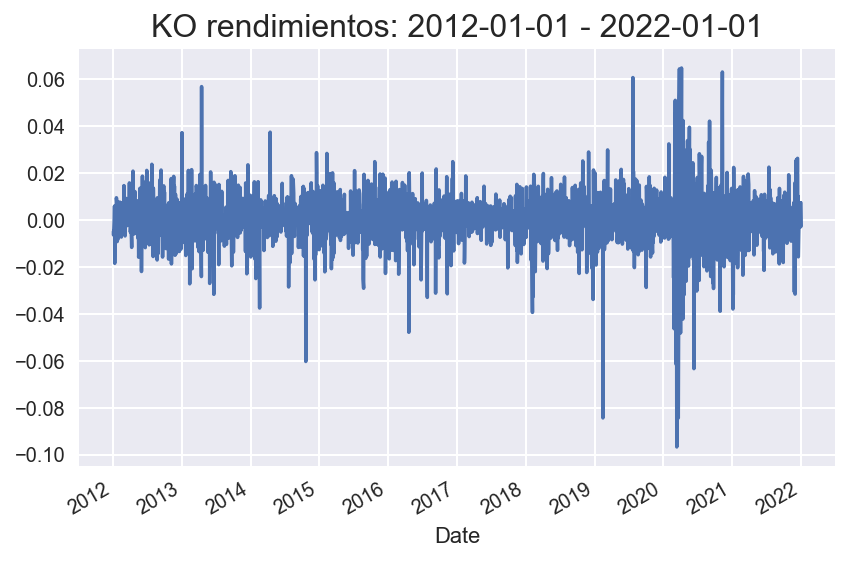

Rendimiento promedio: 0.04%


In [7]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()   

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} rendimientos: {START_DATE} - {END_DATE}', 
             fontsize=16)


plt.tight_layout()
#plt.savefig('imagen1.png')
plt.show()

print(f'Rendimiento promedio: {100 * returns.mean():.2f}%')

Graficamos el histograma para darnos una idea de si realmente siguen una distribución normal o no.

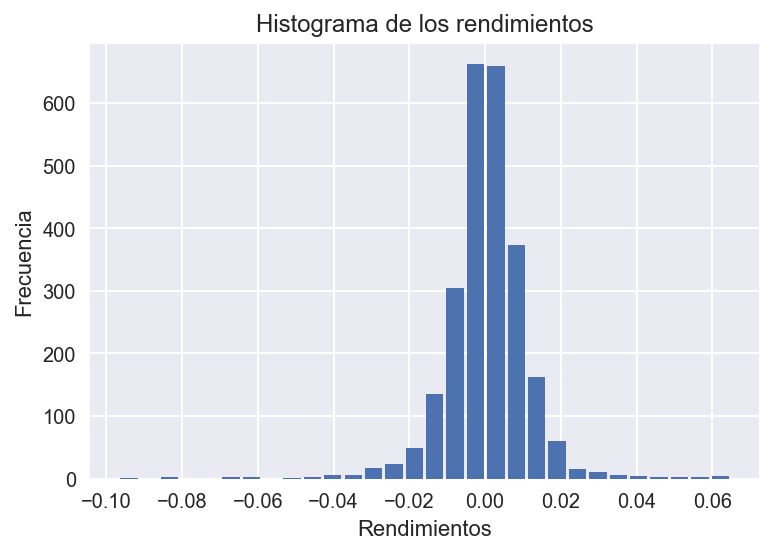

In [8]:
plt.hist(x=returns, rwidth=0.85, bins=30)
plt.title('Histograma de los rendimientos')
plt.xlabel('Rendimientos')
plt.ylabel('Frecuencia')

plt.show()

Es claro que los datos siguen una distribución normal.

##Ahora dividimos el conjunto de datos en dos: un conjunto de entrenamiento y uno de prueba.

Harémos la prueba con 5 grupos

Train: 25% y test: 75%

Train: 50% y test: 50%

Train: 75% y test: 25%

Train: 20% y test: 80%

Train: 80% y test: 20%


##Train: 25% y test: 75%

In [9]:
train = returns['2012-01-01':'2014-05-31']
test = returns['2014-06-01':'2022-01-01']

Definiendo los parámetros de simulación

In [10]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

Comparando la gráfica y el histograma

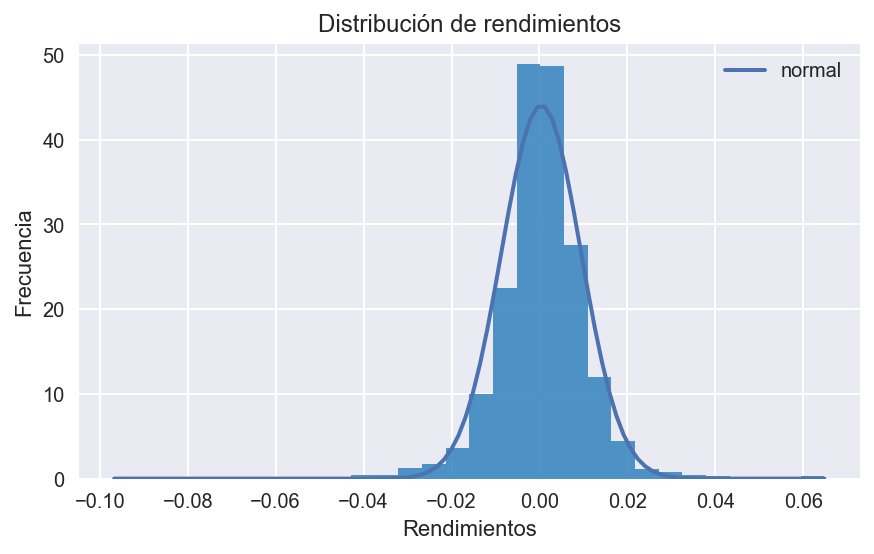

In [11]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

Y la gráfica de cuantiles

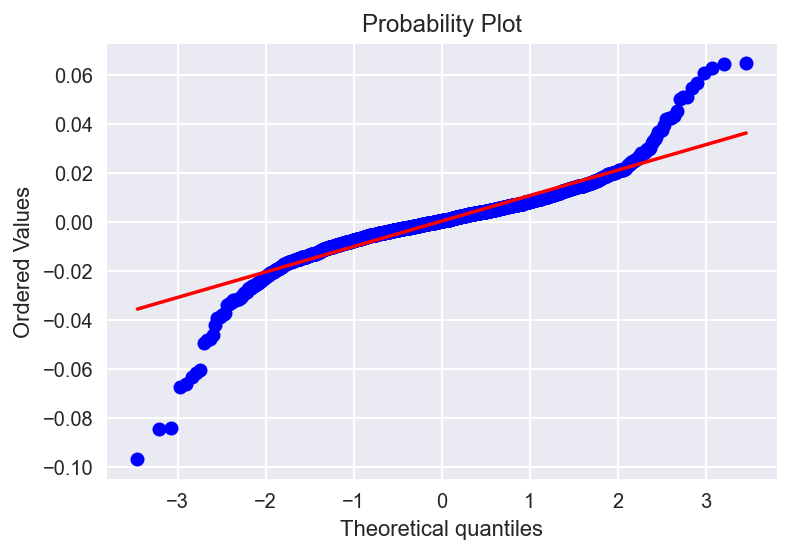

In [12]:
import pylab 
stats.probplot(returns, dist="norm", plot=pylab)
pylab.show()

Haciendo la prueba de kolmogorov

In [13]:
from scipy.stats import kstest
kstest(returns, 'norm', args=(mu, sigma))

KstestResult(statistic=0.04973266611534885, pvalue=7.567720219503245e-06)

Función de la simulación

In [14]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

Corriendo la simulación y graficando los resultados

In [15]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

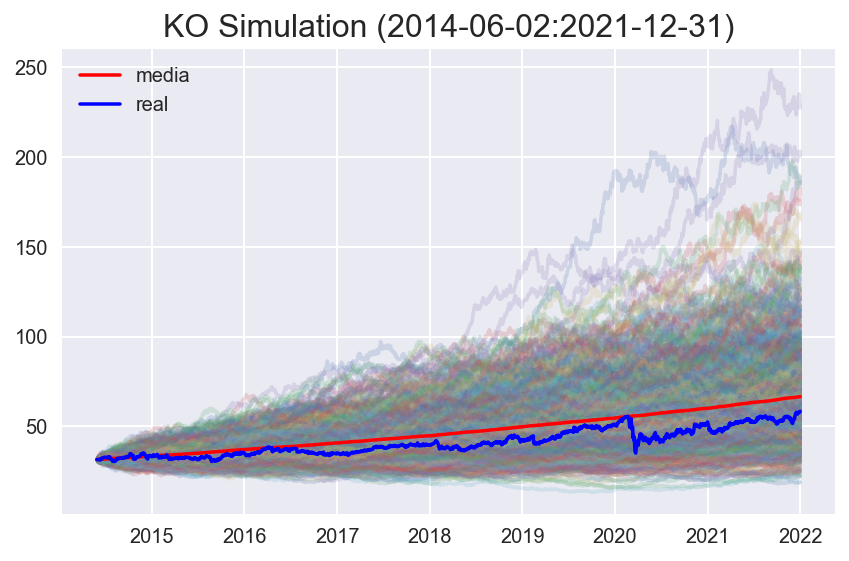

In [16]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

##Train: 50% y test: 50%

In [17]:
train = returns['2012-01-01':'2016-12-31']
test = returns['2017-01-01':'2022-01-01']

Definiendo los parámetros de simulación

In [18]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [19]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

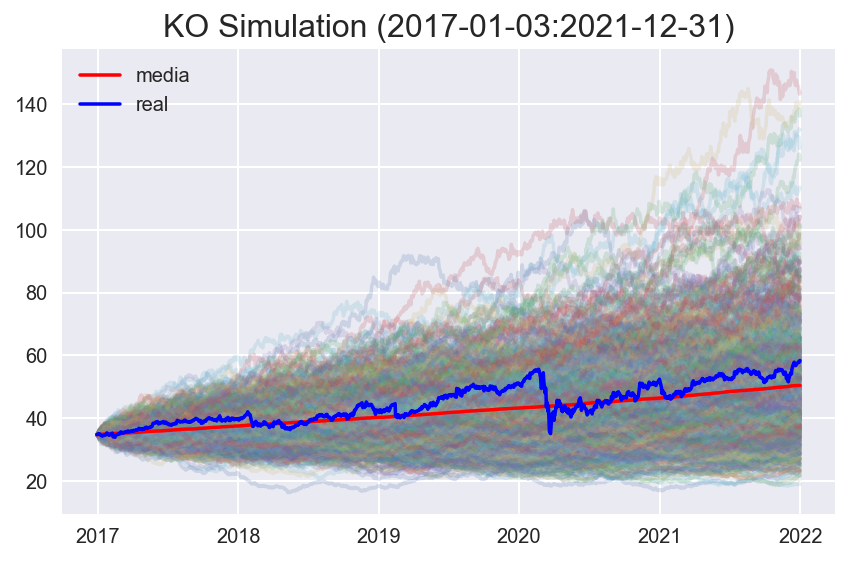

In [20]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

##Train: 75% y test: 25%

In [21]:
train = returns['2012-01-01':'2019-05-31']
test = returns['2019-06-01':'2022-01-01']

Definiendo los parámetros de simulación

In [22]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [23]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

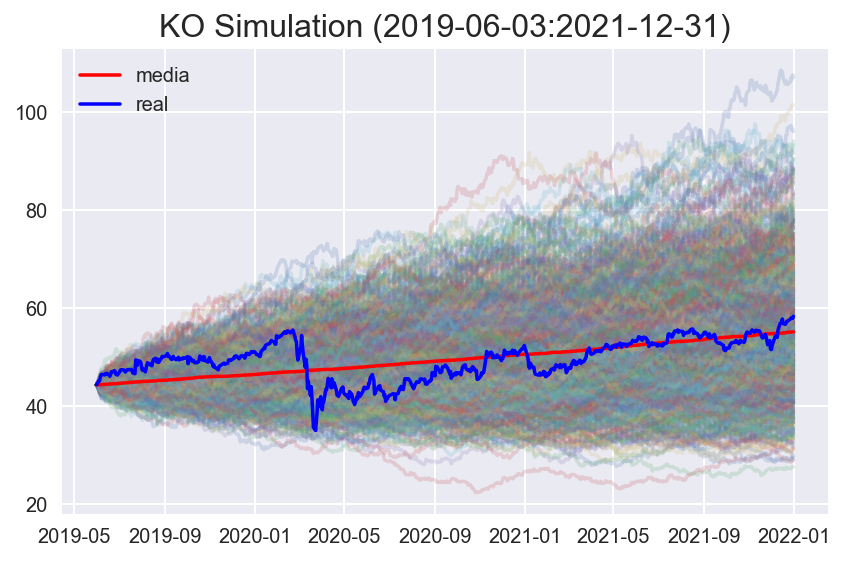

In [24]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

##Train: 20% y test: 80%

In [25]:
train = returns['2012-01-01':'2013-12-31']
test = returns['2014-01-01':'2022-01-01']

Definiendo los parámetros de simulación

In [26]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [27]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

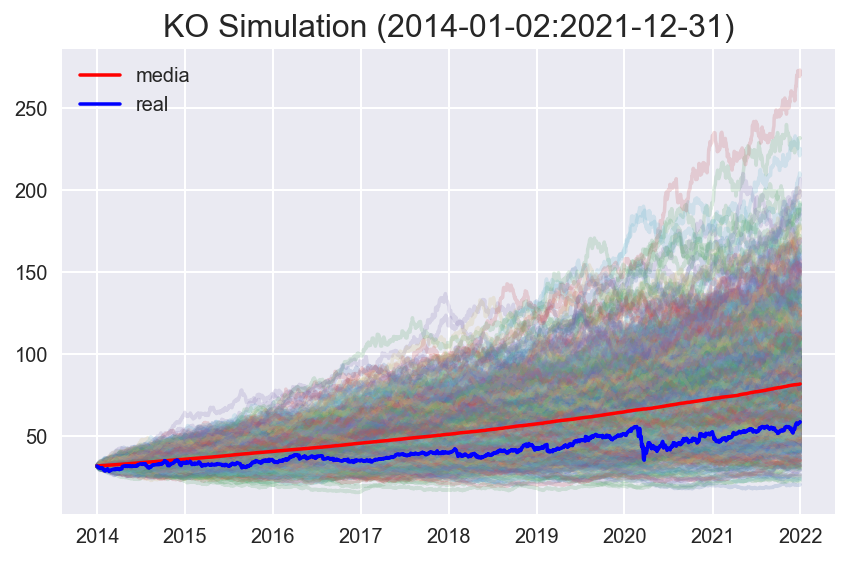

In [28]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

##Train: 80% y test: 20%

In [29]:
train = returns['2012-01-01':'2019-12-31']
test = returns['2020-01-01':'2022-01-01']

Definiendo los parámetros de simulación

In [30]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [31]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

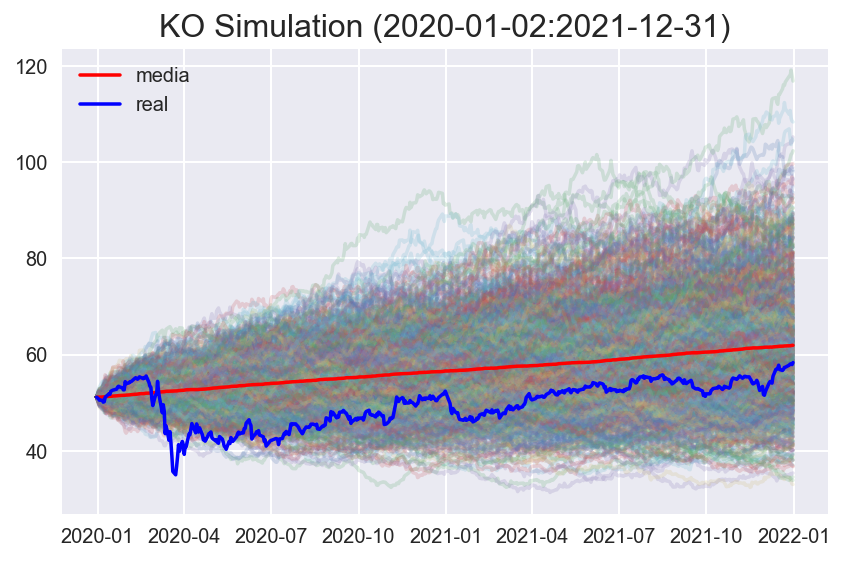

In [32]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()